In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random

import librosa
import librosa.display # must be explicitly imported
import IPython.display as ipd  # for playing .wav files in nb

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings("ignore", message="Numerical issues were encountered ")
warnings.filterwarnings("ignore", message="lbfgs failed to converge ")
warnings.filterwarnings("ignore", message="Precision and F-score are ill-defined")

In [3]:
%%capture
from tqdm.notebook import tqdm
from time import sleep
tqdm().pandas()

In [4]:
# Import CSV
# Source: http://www.openslr.org/83/
df = pd.read_csv('line_index_all.csv', names=['lineID', 'filename', 'transcript'])

# Create label column
df['filename'] = [filename.strip() for filename in df.filename] # Remove whitespace
df['speaker'] = [string[:9] for string in df.filename]
df['source'] = [string[:3] for string in df.filename] # three-letter code indicating speaker dialect+sex (& directory)

In [5]:
# Speaker lists (for shuffling later)

df_wef = df[df.source == 'wef']  # Welsh English Female
df_wem = df[df.source == 'wem']  # Welsh English Male
df_mif = df[df.source == 'mif']  # Midlands English Female
df_mim = df[df.source == 'mim']  # Midlands English Male
df_nof = df[df.source == 'nof']  # Northern English Female
df_nom = df[df.source == 'nom']  # Northern English Male
df_scf = df[df.source == 'scf']  # Scottish English Female
df_scm = df[df.source == 'scm']  # Scottish English Male
df_sof = df[df.source == 'sof']  # Southern English Female
df_som = df[df.source == 'som']  # Southern English Male

speaker_list_we = list(df_wef.speaker.unique()) + list(df_wem.speaker.unique())
speaker_list_mi = list(df_mif.speaker.unique()) + list(df_mim.speaker.unique())
speaker_list_no = list(df_nof.speaker.unique()) + list(df_nom.speaker.unique())
speaker_list_sc = list(df_scf.speaker.unique()) + list(df_scm.speaker.unique())
speaker_list_so = list(df_sof.speaker.unique()) + list(df_som.speaker.unique())

# Class list (in alphabetical order)
labels = ['Midlands', 'Northern', 'Scottish', 'Southern', 'Welsh']

In [6]:
# Feature lists

# MFCCs only
colnames_mfcc16 = []  # n=16 MFCCs

for n in range(16):
    num = n+1
    if num < 10:
        num = '0' + str(num)
    else:
        num = str(num)
    name = 'mfcc_' + num
    colnames_mfcc16.append(name)
    
# MFCC-deltas, MFCC-delta-deltas
# 26-Oct: Do not use, does not add much predictive value
colnames_mfcc16_del = [(name + '_del') for name in colnames_mfcc16]
colnames_mfcc16_del2 = [(name + '_del2') for name in colnames_mfcc16]

# Formants only
# Note 'mif' choice is arbitrary, same column names for every df_formants_*
df_formants = pd.read_pickle("df_formants_colnames.pkl")
colnames_formants = list(df_formants.columns[2:-1])

## Model Development

In [7]:
# Load data
df_full = pd.read_pickle("df_mfcc16s_and_formants.pkl")

In [8]:
# Filter data
# 27-Oct: Remove all Midlands speakers due to small sample size
df_full = df_full[df_full['label'] != 'mi']
labels = ['Northern', 'Scottish', 'Southern', 'Welsh']

### Feature engineering

In [9]:
# Derive formant-related features

# 0. Normalize with respect to F0
for name in colnames_formants[3:]:
    df_full[name] = df_full[name] / df_full['meanF0Hz']
df_full['meanF0Hz'] = 1.0

# 1. F2/F1 (vowel pronunciation)
df_full['f2/f1_mean']   = df_full['f2_mean'] / df_full['f1_mean']
df_full['f2/f1_median'] = df_full['f2_median'] / df_full['f1_median']

# 2. F3/F2 (rhoticity; 'r' sounds)
df_full['f3/f2_mean']   = df_full['f3_mean'] / df_full['f2_mean']
df_full['f3/f2_median'] = df_full['f3_median'] / df_full['f2_median']

# 3. F3/F1 (not sure; for completeness)
df_full['f3/f1_mean']   = df_full['f3_mean'] / df_full['f1_mean']
df_full['f3/f1_median'] = df_full['f3_median'] / df_full['f1_median']

formant_features = list(colnames_formants[3:]) + \
                        ['f2/f1_mean', 'f2/f1_median', 'f3/f2_mean', 'f3/f2_median',
                         'f3/f1_mean', 'f3/f1_median']

In [10]:
# Binary labels for OVR comparisons

df_full['is_scottish'] = np.where(df_full['label'] == 'sc', 1, 0)
df_full['is_welsh']    = np.where(df_full['label'] == 'we', 1, 0)
df_full['is_northern'] = np.where(df_full['label'] == 'no', 1, 0)
df_full['is_southern'] = np.where(df_full['label'] == 'so', 1, 0)

### Model Selection

**Dataset must be split according to speaker ID**. Randomly splitting entries will cause most speakers to be represented in both the train and test datasets. Selecting MFCCs as features would perform extremely well in this context because MFCCs are highly correlated between utterances of any given speaker, but amounts to voice matching, and out-of-sample data/speakers would be poorly identified.

In [11]:
# 1. Train:test split (df_full -> df_train, df_test)

np.random.seed(42)

S = speaker_list_we
random.shuffle(S)
index = int(len(S)*0.8)  # for 80:20 split
speakers_we_test = S[index:]
speakers_we_train = S[:index]
df_train_we = df_full[(df_full.speaker.isin(speakers_we_train) & (df_full.label == 'we'))]
df_test_we = df_full[(df_full.speaker.isin(speakers_we_test) & (df_full.label == 'we'))]

S = speaker_list_no
random.shuffle(S)
index = int(len(S)*0.8)  # for 80:20 split
speakers_no_test = S[index:]
speakers_no_train = S[:index]
df_train_no = df_full[(df_full.speaker.isin(speakers_no_train) & (df_full.label == 'no'))]
df_test_no = df_full[(df_full.speaker.isin(speakers_no_test) & (df_full.label == 'no'))]

S = speaker_list_so
random.shuffle(S)
index = int(len(S)*0.8)  # for 80:20 split
speakers_so_test = S[index:]
speakers_so_train = S[:index]
df_train_so = df_full[(df_full.speaker.isin(speakers_so_train) & (df_full.label == 'so'))]
df_test_so = df_full[(df_full.speaker.isin(speakers_so_test) & (df_full.label == 'so'))]

S = speaker_list_sc
random.shuffle(S)
index = int(len(S)*0.8)  # for 80:20 split
speakers_sc_test = S[index:]
speakers_sc_train = S[:index]
df_train_sc = df_full[(df_full.speaker.isin(speakers_sc_train) & (df_full.label == 'sc'))]
df_test_sc = df_full[(df_full.speaker.isin(speakers_sc_test) & (df_full.label == 'sc'))]

df_train = pd.concat([df_train_we, df_train_no, df_train_so, df_train_sc], axis=0)
df_test =  pd.concat([df_test_we, df_test_no, df_test_so, df_test_sc], axis=0)

print(f'Entries (speakers) in Train dataset:  {df_train.shape[0]} ({len(list(df_train.speaker.unique()))})')
print(f'Entries (speakers) in Test dataset:   {df_test.shape[0]} ({len(list(df_test.speaker.unique()))})')

Entries (speakers) in Train dataset:  13151 (88)
Entries (speakers) in Test dataset:   3580 (24)


In [12]:
# 2. Train:val split (df_train -> df_train2, df_val)

list_train = []
list_val = []

for accent in ['we', 'no', 'so', 'sc']:
    S = list(df_train[df_train['label'] == accent].speaker.unique())
    random.shuffle(S)
    index = int(len(S)*0.75)  # for 75:25 split (train:val)
    speakers_val = S[index:]
    speakers_train = S[:index]
    
    df_train_ = df_train[(df_train.speaker.isin(speakers_train)) & (df_train.label == accent)]
    list_train.append(df_train_)
    df_val_ = df_train[(df_train.speaker.isin(speakers_val)) & (df_train.label == accent)]
    list_val.append(df_val_)
    
df_train2 = pd.concat(list_train, axis=0)
df_val = pd.concat(list_val, axis=0)

print(f'Entries (speakers) in Train dataset:  {df_train2.shape[0]} ({len(list(df_train2.speaker.unique()))})')
print(f'Entries (speakers) in Val dataset:   {df_val.shape[0]} ({len(list(df_val.speaker.unique()))})')

Entries (speakers) in Train dataset:  9556 (64)
Entries (speakers) in Val dataset:   3595 (24)


MFCC-deltas & MFCC-delta2s are **not** used as features in any models below, since introducing them was found to introduce complexity with negligible performance gains, even reducing F1 score for certain classes. (See DataPrep notebook for specific examples.)  However, they can be tested in the current notebook by adding the feature lists `colnames_mfcc16_del` and/or `colnames_mfcc16_del2` to `colnames_mfcc16` in X_train/val/test below.

### Tuning

**KNN: k=5**  
Cross-validated F1 score seems to take a maximum where k = 3, in all four classes. However, k=4 and k=5 seem reasonably close to the maximum, and could help to reduce variance.

In [13]:
X = df_train[colnames_mfcc16+formant_features]
y_sc = df_train['is_scottish']
y_we = df_train['is_welsh']
y_no = df_train['is_northern']
y_so = df_train['is_southern']

k_range = list(range(1,31))
k_scores_sc = []
k_scores_so = []
k_scores_no = []
k_scores_we = []
k_scores_all = []

for k in tqdm(k_range):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y_sc, cv=10, scoring='f1')  # y_sc = Scottish v. rest, etc.
    k_scores_sc.append(scores.mean())
    scores = cross_val_score(knn, X, y_so, cv=10, scoring='f1')  
    k_scores_so.append(scores.mean())
    scores = cross_val_score(knn, X, y_no, cv=10, scoring='f1')  
    k_scores_no.append(scores.mean())
    scores = cross_val_score(knn, X, y_we, cv=10, scoring='f1') 
    k_scores_we.append(scores.mean())
    score = (k_scores_sc[-1] + k_scores_so[-1] +
             k_scores_no[-1] + k_scores_we[-1]) / 4
    k_scores_all.append(score)

fig, ax = plt.subplots()

ax.plot(k_scores_sc, color = 'green', label = 'Scottish')
ax.plot(k_scores_we, color = 'blue', label = 'Welsh')
ax.plot(k_scores_no, color = 'yellow', label = 'Northern')
ax.plot(k_scores_so, color = 'red', label = 'Southern')
ax.plot(k_scores_all, color = 'black', label = '4-CLASS MEAN')
ax.legend(loc = 'upper right')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F1 Score')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# For checking CV scores of different models and parameters

model = KNeighborsClassifier(n_neighbors=) # enter k here
# model = LogisticRegression(solver='liblinear')   # optional: class_weight='balanced'
# model = DecisionTreeClassifier(max_depth=)
# model = RandomForestClassifier(n_estimators=) # optional: class_weight='balanced'

X = df_train[colnames_mfcc16]
y_sc = df_train['is_scottish']
y_we = df_train['is_welsh']
y_no = df_train['is_northern']
y_so = df_train['is_southern']

scores_sc = cross_val_score(knn, X, y_sc, cv=10, scoring='f1')
scores_we = cross_val_score(knn, X, y_we, cv=10, scoring='f1')
scores_no = cross_val_score(knn, X, y_no, cv=10, scoring='f1')
scores_so = cross_val_score(knn, X, y_so, cv=10, scoring='f1')

print(f'CV scores for Scottish: Mean={np.mean(scores_sc)}, \n List: {scores_sc}')
print(f'CV scores for Welsh:    Mean={np.mean(scores_we)}, \n List: {scores_we}')
print(f'CV scores for Northern: Mean={np.mean(scores_no)}, \n List: {scores_no}')
print(f'CV scores for Southern: Mean={np.mean(scores_so)}, \n List: {scores_so}')

mean_CV = np.mean([np.mean(scores_sc), np.mean(scores_we),  
                   np.mean(scores_so), np.mean(scores_no)])

print(f'\n Mean CV across all four classes: {mean_CV}')

**Decision tree: max_depth = 3**  
Shallower decision trees seem to generalize better.

In [ ]:
depth_range = list(range(1,31))
max_depth_sc = []
max_depth_so = []
max_depth_no = []
max_depth_we = []
max_depth_mean = []

for maxdepth in tqdm(depth_range):
    dtc = DecisionTreeClassifier(max_depth=maxdepth)
    scores = cross_val_score(dtc, X, y_sc, cv=10, scoring='f1')  # y_sc = Scottish v. rest, etc.
    max_depth_sc.append(scores.mean())
    scores = cross_val_score(dtc, X, y_so, cv=10, scoring='f1')  
    max_depth_so.append(scores.mean())
    scores = cross_val_score(dtc, X, y_no, cv=10, scoring='f1')  
    max_depth_no.append(scores.mean())
    scores = cross_val_score(dtc, X, y_we, cv=10, scoring='f1') 
    max_depth_we.append(scores.mean())
    score = (max_depth_sc[-1] + max_depth_so[-1] +
             max_depth_no[-1] + max_depth_we[-1]) / 4
    max_depth_mean.append(score)

fig, ax = plt.subplots()

ax.plot(max_depth_sc, color = 'green', label = 'Scottish')
ax.plot(max_depth_we, color = 'blue', label = 'Welsh')
ax.plot(max_depth_no, color = 'yellow', label = 'Northern')
ax.plot(max_depth_so, color = 'red', label = 'Southern')
ax.plot(max_depth_mean, color = 'black', label = '4-CLASS MEAN')
ax.legend(loc = 'upper right')
plt.xlabel('Max_depth - DecisionTreeClassifier')
plt.ylabel('Cross-Validated F1 Score')
plt.show()

**Logistic regression:**  C=0.01  
Determined best regularization strength using GridSearchCV.

In [15]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced')

parameters = {
     "C"    : [0.01, 0.10, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
     }

grid = GridSearchCV(lr,
                     parameters, n_jobs=4,
                     scoring="neg_log_loss",
                     cv=3)

X_train = df_train[colnames_mfcc16+formant_features]
y_train = df_train['label']
grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 0.01}


**Random forest: n_estimators = 100**  
No appreciable change in F1 score over the range examined.

In [ ]:
est_range = list(range(5,205,5))
n_est_sc = []
n_est_so = []
n_est_no = []
n_est_we = []
n_est_mean = []

for n_est in tqdm(est_range):
    rf = RandomForestClassifier(n_estimators=n_est)
    scores = cross_val_score(rf, X, y_sc, cv=10, scoring='f1')  # y_sc = Scottish v. rest, etc.
    n_est_sc.append(scores.mean())
    scores = cross_val_score(rf, X, y_so, cv=10, scoring='f1')  
    n_est_so.append(scores.mean())
    scores = cross_val_score(rf, X, y_no, cv=10, scoring='f1')  
    n_est_no.append(scores.mean())
    scores = cross_val_score(rf, X, y_we, cv=10, scoring='f1') 
    n_est_we.append(scores.mean())
    score = (n_est_sc[-1] + n_est_so[-1] +
             n_est_no[-1] + n_est_we[-1]) / 4
    n_est_mean.append(score)

In [ ]:
fig, ax = plt.subplots()
# multiply x-axis value by 5 for n_estimators: e.g. '20' * 5 = 100

ax.plot(n_est_sc, color = 'green', label = 'Scottish')
ax.plot(n_est_we, color = 'blue', label = 'Welsh')
ax.plot(n_est_no, color = 'yellow', label = 'Northern')
ax.plot(n_est_so, color = 'red', label = 'Southern')
ax.plot(n_est_mean, color = 'black', label = '4-CLASS MEAN')
ax.legend(loc = 'upper right')
plt.xlabel('Number of estimators (RF)')
plt.ylabel('Cross-Validated F1 Score')
plt.show()

**XGBoost:** Parameters optimized (for multiclass) using GridSearchCV:

In [ ]:
# DO NOT RE-RUN: processing takes FOREVER
# Result (multiclass): {'colsample_bytree': 0.7, 'eta': 0.05, 'gamma': 0.0, 'max_depth': 15, 'min_child_weight': 1}

# X_train = df_train2[colnames_mfcc16+formant_features]  
# y_train = df_train2['label']
# X_val   = df_val[colnames_mfcc16   +formant_features]
# y_val   = df_val['label']
# X_test  = df_test[colnames_mfcc16  +formant_features]
# y_test  = df_test['label']

# clf = xgb.XGBClassifier(use_label_encoder=False)

# parameters = {
#      "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
#      "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#      "min_child_weight" : [ 1, 3, 5, 7 ],
#      "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#      "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
#      }

# grid = GridSearchCV(clf,
#                     parameters, n_jobs=4,
#                     scoring="neg_log_loss",
#                     cv=3)

# grid.fit(X_train, y_train)
# print(grid.best_params_)

## Current models

In [16]:
def get_confusion_matrix(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', \
            fmt='g', xticklabels=labels, yticklabels=labels, ax=ax)

    print(classification_report(y_test, y_pred))

1-4. **KNN, logistic regression, decision tree, and random forest**

              precision    recall  f1-score   support

          no       0.60      0.25      0.35       600
          sc       0.31      0.14      0.19       600
          so       0.66      0.85      0.74      1780
          we       0.48      0.61      0.54       600

    accuracy                           0.59      3580
   macro avg       0.51      0.46      0.45      3580
weighted avg       0.56      0.59      0.55      3580



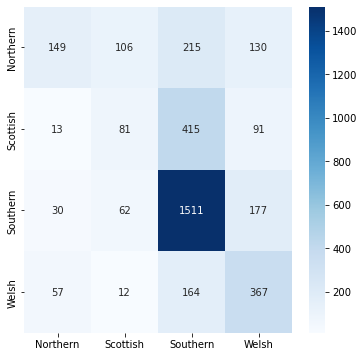

In [19]:
X_train = df_train[colnames_mfcc16+formant_features]
y_train = df_train['label']
X_test = df_test[colnames_mfcc16+formant_features]
y_test = df_test['label']

# model = KNeighborsClassifier(n_neighbors=5)
model = LogisticRegression(C=0.1, solver='liblinear')      # optional: class_weight='balanced'
# model = DecisionTreeClassifier(max_depth=16, class_weight='balanced')        # optional: class_weight='balanced'
# model = RandomForestClassifier(n_estimators=100, class_weight='balanced')    # optional: class_weight='balanced'

get_confusion_matrix(model)

In [ ]:
# Feature importance: Logistic

importance = model.coef_
df_feat = pd.DataFrame(importance.T, index = [colnames_mfcc16+formant_features], columns=labels)

for i, col in enumerate(df_feat):
    colname = labels[i][:2] + '_abs'
    df_feat[colname] = np.abs(df_feat[labels[i]]) 
    
df_feat.sort_values('No_abs', ascending=False, inplace=True)  # 'No_abs', Sc_abs', 'So_abs', 'We_abs' for different classes
print(df_feat.loc[:, 'Northern'][:11])
df_feat.sort_values('Sc_abs', ascending=False, inplace=True)  # 'No_abs', Sc_abs', 'So_abs', 'We_abs' for different classes
print(df_feat.loc[:, 'Scottish'][:11])
df_feat.sort_values('So_abs', ascending=False, inplace=True)  # 'No_abs', Sc_abs', 'So_abs', 'We_abs' for different classes
print(df_feat.loc[:, 'Southern'][:11])
df_feat.sort_values('Sc_abs', ascending=False, inplace=True)  # 'No_abs', Sc_abs', 'So_abs', 'We_abs' for different classes
print(df_feat.loc[:, 'Welsh'][:11])

In [38]:
# Feature importance: Random forest

# Scale features for interpretability
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

df_scaled = df_full.iloc[:,:8]

for col in df_full[colnames_mfcc16+formant_features]:
    df_scaled[[col]] = std.fit_transform(df_full[[col]])

S = speaker_list_we
random.shuffle(S)
index = int(len(S)*0.8)  # for 80:20 split
speakers_we_test = S[index:]
speakers_we_train = S[:index]
df_train_we = df_scaled[(df_scaled.speaker.isin(speakers_we_train) & (df_scaled.label == 'we'))]
df_test_we = df_scaled[(df_scaled.speaker.isin(speakers_we_test) & (df_scaled.label == 'we'))]

S = speaker_list_no
random.shuffle(S)
index = int(len(S)*0.8)  # for 80:20 split
speakers_no_test = S[index:]
speakers_no_train = S[:index]
df_train_no = df_scaled[(df_scaled.speaker.isin(speakers_no_train) & (df_scaled.label == 'no'))]
df_test_no = df_scaled[(df_scaled.speaker.isin(speakers_no_test) & (df_scaled.label == 'no'))]

S = speaker_list_so
random.shuffle(S)
index = int(len(S)*0.8)  # for 80:20 split
speakers_so_test = S[index:]
speakers_so_train = S[:index]
df_train_so = df_scaled[(df_scaled.speaker.isin(speakers_so_train) & (df_scaled.label == 'so'))]
df_test_so = df_scaled[(df_scaled.speaker.isin(speakers_so_test) & (df_scaled.label == 'so'))]

S = speaker_list_sc
random.shuffle(S)
index = int(len(S)*0.8)  # for 80:20 split
speakers_sc_test = S[index:]
speakers_sc_train = S[:index]
df_train_sc = df_scaled[(df_scaled.speaker.isin(speakers_sc_train) & (df_scaled.label == 'sc'))]
df_test_sc = df_scaled[(df_scaled.speaker.isin(speakers_sc_test) & (df_scaled.label == 'sc'))]

df_train = pd.concat([df_train_we, df_train_no, df_train_so, df_train_sc], axis=0)
df_test =  pd.concat([df_test_we, df_test_no, df_test_so, df_test_sc], axis=0)

X_train = df_train[colnames_mfcc16+formant_features]
y_train = df_train['label']
    
rf100 = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf100.fit(X_train, y_train)
importances = rf100.feature_importances_
avg = np.mean([tree.feature_importances_ for tree in rf100.estimators_], axis=0)

# View features by importance
df_feat = pd.DataFrame(avg.T, index = [colnames_mfcc16+formant_features], columns=['feat_imp'])
df_feat.sort_values('feat_imp', ascending=False, inplace=True)
df_feat.head(10)

5. **XGBoost (gradient boosting trees):**

In [20]:
# For multiclass
X_train = df_train2[colnames_mfcc16+
                  formant_features]  
y_train = df_train2['label']
X_val = df_val[colnames_mfcc16+
                formant_features]
y_val = df_val['label']
X_test = df_test[colnames_mfcc16+formant_features]
y_test = df_test['label']

# For single-class
# (y = 'is_scottish', 'is_welsh', 'is_northern', 'is_southern')
# X_train = df_train2[colnames_mfcc16+
#                   formant_features]  
# y_train = df_train2['is_southern']
# X_val = df_val[colnames_mfcc16+
#                 formant_features]
# y_val = df_val['is_southern']
# X_test = df_test[colnames_mfcc16+formant_features]
# y_test = df_test['is_southern']

In [23]:
# Optimized model
gbm = xgb.XGBClassifier(n_estimators=30000,
                       max_depth=15,
                       #objective='binary:logistic',   # comment out for multiclass 
                       objective='multi:softprob',   # comment out for one class
                       learning_rate=.05,
                       subsample=.8,
                       min_child_weight=1,
                       colsample_bytree=.7)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit(X_train, y_train,
                   eval_set=eval_set,
                   #eval_metric='logloss',            # comment out for multiclass
                   eval_metric='mlogloss',          # comment out for one class
                   early_stopping_rounds=50,
                   verbose=False)

accuracy_score(y_test, gbm.predict(X_test))

0.5488826815642458

6. **Naive Bayes (multinomial)**  
Need to preprocess MFCCs (because negative data not permitted), then re-do split before testing:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mmx = MinMaxScaler()

for col in df_full[colnames_mfcc16]:
    df_full[[col]] = mmx.fit_transform(df_full[[col]])

In [ ]:
# Re-run train:test split (df_full -> df_train, df_test) under "Model Selection"

In [ ]:
X_train = df_train[colnames_mfcc16+formant_features]
y_train = df_train['label']
X_test = df_test[colnames_mfcc16+formant_features]
y_test = df_test['label']

model = MultinomialNB()

get_confusion_matrix(model)

### Reference: Multi-class ROC-AUC

In [ ]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

In [ ]:
# from sklearn.utils import shuffle
# X_s, y_s = shuffle(X, y)
# cross_val_score(knn, X_s, y_s, cv=3, scoring="roc_auc")

In [ ]:
print(f1_score(y_test, y_pred, average='weighted'))
print(roc_auc_score_multiclass(y_test, y_pred, average='weighted'))

### Reference: Audio processing of a single file

In [ ]:
# 1. Generate path
path = 'midlands_english_female/' + 'mif_02484_00047480027' + '.wav'

# 2. Import audio file
y, sr = librosa.load(path, sr=22050)

In [ ]:
# 3. Calculate MFCCs
# 3.1 Import wav file

path = 'midlands_english_female/mif_02484_00047480027.wav'
y, sr = librosa.load(path, sr=22050)  # 'data are stored at 48 kHz' in publication
ipd.Audio(path)

In [ ]:
# 3.2 Plot speech waveform

plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

In [ ]:
# 3.3 Calcuate MFCCs

mfccs = librosa.feature.mfcc(y=y, sr=sr)
#mfccs = preprocessing.scale(mfccs, axis=1)  # for use in MVP fig only!

In [ ]:
# 3.4 Plot spectrogram

D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ipd.Audio(path)

In [ ]:
# 3.5 Plot MFCC spectra

fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCCs (unscaled)')